In [1]:
from cvxpy import *
import numpy as np
from multiprocessing import Process, Pipe
from scipy import sparse
import cvxpy as cp

In [2]:
# Number of robots.
N = 3

#Discrete time horizon
T = 10

# Dimension of the state space (2D pose for each robot :( x, y, theta) ).
nx = 6 * N

# Dimension of the input space ((v_x, v_y) for each robot)
nu = 3 * N

# Discrete time model of a double integrator (in R^3)
# x:(px,py,pz,vx,vy,vz)
# u:(ax,ay,az)
h = 0.1 #Discretization interval
Ad = sparse.csc_matrix([[1 ,0 ,0, h, 0, 0],
                        [0, 1 ,0, 0, h, 0],
                        [0, 0, 1, 0, 0, h],
                        [0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 1]])

Bd = sparse.csc_matrix([[h**2/2, 0, 0],
                        [0,h**2/2, 0],
                        [0 , 0, h**2/2],
                        [h, 0, 0],
                        [0, h, 0],
                        [0, 0, h]])

# List of all the f_i functions for each robot.
f_list = []


# Initialize robot positions and goal positions randomly.
np.random.seed(0)
# robot_positions = np.random.rand(N, 3)  # Random initial positions.
goal_state = np.random.rand(N, 6)*2   # Random goal positions.
for i in range(goal_state.shape[0]):
  goal_state[i][3:] = np.zeros(3)

# Formulate the model predictive control problem.
objective = 0
Q = np.eye(6)
R = np.eye(3)*0.1
Qf = Q*10
f_list = []
x0 = np.array([1.5,2.5,1,0,0,0,
                   -1.5,1.1,1,0, 0, 0,
                   -2.5, 1.5, 1, 0, 0, 0 ])

xr = np.array([-1.5,0.5,1,0,0,0,
                1.5,-1.1,1,0, 0, 0,
              2.5, -1.5, 1, 0, 0, 0 ])



In [3]:
def distance_to_goal(x,xf,n_agents,n_states):
    n_d = 3
    return np.linalg.norm((x - xf).reshape(n_agents, n_states)[:, :n_d], axis=1)


In [10]:
# Parameters for the ADMM algorithm.
rho = 0.5
MAX_ITER = 30
r_min = 0.3*2
# Parameters for ADMM.
# MAX_ITER_ADMM = 15
neighbors = [[1,2],[0,2],[0,1]]  # List of neighbor indices for each agent including itself

def run_worker(agent_idx, pipe, x_curr):
    pk = Parameter((T+1)*nx + T*nu, value=np.zeros(((T+1)*nx + T*nu)))
    x_init = Parameter(6 , value = np.zeros(6))
    xi = Variable((T+1)*nx + T*nu)
    constr = []
    constr += [xi[agent_idx*6:(agent_idx+1)*6] ==x_init]
    x_init.value = x_curr[agent_idx*6:(agent_idx+1)*6]
    objective_i = 0
    for t in range(T):
      objective_i += quad_form(xi[:(T+1)*nx][t*nx:(t+1)*nx][i*6:(i+1)*6]-xr[agent_idx*6:(agent_idx+1)*6], Q) \
                      + quad_form(xi[(T+1)*nx:][t*nu:(t+1)*nu][i*3:(i+1)*3], R)

    objective_i += quad_form(xi[T*nx:(T+1)*nx][i*6:(i+1)*6]-xr[agent_idx*6:(agent_idx+1)*6], Qf)
    for k in range(T):
      x_next = Ad@xi[:(T+1)*nx][(k)*nx:(k+1)*nx][agent_idx*6:(agent_idx+1)*6] + Bd@xi[(T+1)*nx:][k*nu:(k+1)*nu][agent_idx*3:(agent_idx+1)*3]
      constr += [xi[:(T+1)*nx][(k+1)*nx:(k+2)*nx][agent_idx*6:(agent_idx+1)*6] == x_next]
      constr += [abs(xi[(T+1)*nx:][(k)*nu:(k+1)*nu][agent_idx*3:(agent_idx+1)*3]) <= np.array([2, 2, 2])]
      #Collision avoidance via Buffered Voronoi Cells:
      p_i_prev = x_curr[agent_idx*6:(agent_idx+1)*6][:3]
      p_i_next = x_next[:3]
      for j in range(N):
        if j != agent_idx:
          # continue
          p_j_prev = x_curr[j*6:(j+1)*6][:3]

          a_ij  =  (p_i_prev -p_j_prev)/cp.norm(p_i_prev -p_j_prev)
          b_ij = a_ij @ (p_i_prev + p_j_prev)/2 + r_min/2
          constr += [ (a_ij @ p_i_next) >= b_ij ]

    dual_update = 0
    while True:
        # Primal update
        primal_objective = objective_i + pk.T @ xi
        x_neighbor = pipe.recv()
        for neighbor_i in neighbors[agent_idx]:
          for neighbor_j in neighbors[agent_idx]:
              if neighbor_j != neighbor_i and neighbor_i < neighbor_j:
                # print(neighbor_i, neighbor_j)
                primal_objective += rho/2 * sum_squares(xi - (x_neighbor[neighbor_j] + x_neighbor[neighbor_i])/2)

        primal_problem = Problem(Minimize(primal_objective),constr)
        primal_problem.solve()

        pipe.send((xi.value))
        # Dual update
        for neighbor_idx in neighbors[agent_idx]:
            dual_update += (xi.value - x_neighbor[neighbor_idx])
        pk.value += rho * dual_update


In [11]:
## Run in receding-horizon fashion:
# Setup the workers.
mpc_iter =0
x_curr = x0
x_dims = [6]*N
n_dims = [3]*N
primal_err_record = []
X_full = np.zeros((0, nx))
X_full = np.r_[X_full, x_curr.reshape(1,-1)]
while not np.all(distance_to_goal(x_curr,xr,N,6)) <= 0.1:
  
  pipes = []
  procs = []
  for i in range(N):
      local, remote = Pipe()
      pipes += [local]
      procs += [Process(target=run_worker, args=(i, remote, x_curr))]
      procs[-1].start()

  # ADMM loop.
  # sol_dict = {}
  ## Set up empty lsits for recording the primal feasibility and dual feasibility
  # primal_err = []
  # dual_err = []
  x_neighbor = [np.zeros((T+1)*nx + T*nu) for _ in range(N)]

  primal_err = [np.inf]
  admm_iter = 0
  for _ in range(MAX_ITER):
      x_i_local = []
      for i, pipe in enumerate(pipes):
          pipe.send(x_neighbor)
          xi_values = pipe.recv()
          x_i_local.append(xi_values)
          # sol_dict["agent{0}".format(i)] = xi_values
      x_neighbor = x_i_local
      err = 0
      for i in range(len(x_i_local)):
        for j in range(1,len(x_i_local)-1): #Check these indices
          err += np.linalg.norm(x_i_local[i]-x_i_local[j])

      primal_err.append(err)
      admm_iter += 1
      if np.abs(primal_err[admm_iter]-primal_err[admm_iter-1]) <= 0.05:
        break

  [p.terminate() for p in procs]
  primal_err_record.append(primal_err)
  x_curr = x_i_local[-1][:(T+1)*nx].reshape((T+1,nx))[1,:]
  u_curr = x_i_local[-1][(T+1)*nx:].reshape((T,nu))[0,:]
  X_full = np.r_[X_full, x_curr.reshape(1,-1)]
  mpc_iter += 1
  print(f'Current MPC iteration is {mpc_iter}')
  if mpc_iter > 35:
    print('Max MPC iters reached!')
    break


Current MPC iteration is 1
Current MPC iteration is 2
Current MPC iteration is 3
Current MPC iteration is 4
Current MPC iteration is 5
Current MPC iteration is 6
Current MPC iteration is 7
Current MPC iteration is 8
Current MPC iteration is 9
Current MPC iteration is 10
Current MPC iteration is 11
Current MPC iteration is 12
Current MPC iteration is 13
Current MPC iteration is 14
Current MPC iteration is 15
Current MPC iteration is 16
Current MPC iteration is 17
Current MPC iteration is 18
Current MPC iteration is 19
Current MPC iteration is 20
Current MPC iteration is 21
Current MPC iteration is 22
Current MPC iteration is 23
Current MPC iteration is 24
Current MPC iteration is 25
Current MPC iteration is 26
Current MPC iteration is 27
Current MPC iteration is 28
Current MPC iteration is 29
Current MPC iteration is 30
Current MPC iteration is 31
Current MPC iteration is 32
Current MPC iteration is 33
Current MPC iteration is 34
Current MPC iteration is 35
Current MPC iteration is 36
M

Text(0.5, 0, 'ADMM Iterations ')

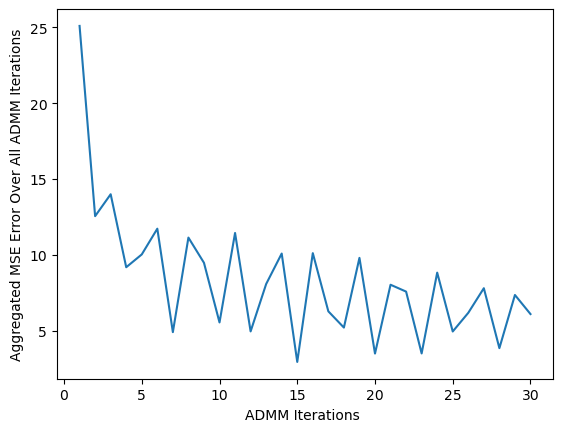

In [15]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(primal_err_record[10])
plt.ylabel('Aggregated MSE Error Over All ADMM Iterations')
plt.xlabel('ADMM Iterations ')